# CAM + YOLOv3 for Detecting Numbers on Mailbox in Streetview Images

**YOLOv3 from https://github.com/ultralytics/yolov3**

**CAM Implementation and Visualization from https://github.com/JimEverest/CAM** 

**Images from Google Street View, only for Visualization Purpose** 

**Street View House Number dataset (Format 1) from http://ufldl.stanford.edu/housenumbers/**

## Clone 'yolov3' from Ultralytics

In [ ]:
!git clone https://github.com/ultralytics/yolov3 
%cd yolov3
!pip install -r requirements.txt

## Import 

In [4]:
import os
import numpy as np
import torch
import torchvision
import PIL
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
import urllib.request
from torchvision import transforms
import subprocess

## Check ResNet34 structure

In [5]:
resnet34 = torchvision.models.resnet34(weights='DEFAULT')
model = resnet34

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Generate a single proposal for YOLOv3 to detect

In [6]:

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convert image to RGB, dropping alpha if present
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


In [7]:

def generate_region_proposal(img, visualize=False):
    
    # preprocess
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0) # add dimension at front
    
    # use ResNet34 with pretrained weights
    model = torchvision.models.resnet34(weights='DEFAULT')
    
    # check prediction output of resnet and print top 5 results
    check_resnet_prediction(model, batch_t)
    
    # generate and store heatmap in 'y_0'
    y_0 = generate_attention_1(model, img, visualize=visualize)

    # find bbox and visualize
    visualized_image, bbox = extract_main_feature_box(y_0, img, visualize=visualize)
    
    return bbox


In [8]:

# this function is revised based on: https://github.com/JimEverest/CAM
def check_resnet_prediction(model, img_tensor):
    
    topk=5
    
    # add path to labels?
    with open('/Users/zhaozhiyu/Downloads/imagenet_classes.txt', 'r') as f:  
        labels = [line.strip() for line in f.readlines()]
    
    model.eval()
    out = model(img_tensor)
    
    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    
    print(f'ResNet34 Top {topk} Predictions:')
    for idx in indices[0][:topk]:
        print(f'Class {labels[idx]}, Classification Percentage: {percentage[idx].item():.2f}%')
    print()



In [9]:

# this function is revised based on: https://github.com/JimEverest/CAM
def generate_attention_1(model, img, class_index=637, size=(1024, 1024), visualize=False):
    
    # remove last 2 layers
    newmodel = torch.nn.Sequential(*(list(model.children())[:-2]))
    
    # load and preprocess image
    # save a copy so do not change size of original image
    img_processed = img.copy()
    img_processed.thumbnail(size, Image.LANCZOS)
    # print('Processed image shape:', img_processed.size)
    
    batch_t = transform(img_processed)[None]
    
    # extract weights from the last FC layer
    m_weights = model.fc.weight.data[class_index]
    # print(m_weights.shape)  # torch.Size([512])
    
    # forward pass
    fms = newmodel(batch_t)  # [1, 512, 7, 7]
    fms = fms.squeeze(0)  # [512, 7, 7]
    out_t = fms * m_weights[:, None, None]
    y_0 = torch.mean(out_t, dim=0)  # AVG on channel dim. [512, 7, 7] --> [7, 7]

    # visualization
    if visualize:
        plt.figure(figsize=(18, 6))
        fontsize = 15

        ax = plt.subplot(1, 3, 1)
        plt.title('Original Image')
        ax.axis('off')
        plt.imshow(img)

        ax = plt.subplot(1, 3, 2)
        plt.title('CAM Heatmap')
        ax.axis('off')
        plt.imshow(y_0.detach().numpy())

        ax = plt.subplot(1, 3, 3)
        plt.title('CAM Heatmap on Original Image')
        ax.axis('off')
        ax.imshow(img)
        ax.imshow(y_0.detach().numpy(), alpha=0.6, interpolation='bilinear', cmap='magma',
                  extent=(0, img.size[0], img.size[1], 0))

        plt.tight_layout()
    
    return y_0


In [10]:

def extract_main_feature_box(heatmap, original_image, threshold_value=0.6, visualize=False):
    
    # convert heatmap tensor to numpy array
    heatmap = heatmap.detach().numpy()
    
    # normalize heatmap by dividing max value --> [0,1]
    normalized_heatmap = heatmap / heatmap.max()
    
    # hyperparameter 'threshold_value' --> high value for tight cropping, low value for loose cropping
    _, binary_heatmap = cv2.threshold(normalized_heatmap, threshold_value, 255, cv2.THRESH_BINARY)
    
    # convert to 8-bit image for findContours
    binary_heatmap = (binary_heatmap * 255).astype(np.uint8)

    contours, _ = cv2.findContours(binary_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # compute dimensions for both original image and heatmap for scaling
    original_width, original_height = original_image.size
    heatmap_width, heatmap_height = heatmap.shape[1], heatmap.shape[0]

    x_scale = original_width / heatmap_width
    y_scale = original_height / heatmap_height

    original_image_draw = np.array(original_image.convert('RGB'))

    # find the largest contour 
    # if multiple mailboxes are present, only generate a single bbox around the largest/most prominent one
    if contours:
        max_area = 0
        best_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                best_contour = contour

        # compute bounding box, scale to display on original image
        x, y, w, h = cv2.boundingRect(best_contour)
        x = int(x * x_scale)
        y = int(y * y_scale)
        w = int(w * x_scale)
        h = int(h * y_scale)

        cv2.rectangle(original_image_draw, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # visualization
    if visualize:
        fontsize = 15
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        plt.title('Original Image with Region Proposal')
        plt.imshow(original_image_draw)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Binary Heatmap')
        plt.imshow(binary_heatmap, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Binary Heatmap with Contours')
        binary_heatmap_color = cv2.cvtColor(binary_heatmap, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(binary_heatmap_color, contours, -1, (0, 255, 0), 3)
        plt.imshow(binary_heatmap_color)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    if contours:
        print(f'Contour found with coordinates: ({x}, {y}, {x+w}, {y+h})')
        return original_image_draw, (x, y, x+w, y+h)
    else:
        print('No contour found...')
        return (None, None, None, None)


## Use generated proposal for YOLOv3 detection

In [21]:

def crop_and_detect_yolo(img, bbox, conf_score, weights_path, output_dir, img_path, visualize=False):
    
     # crop the image according to the given bounding box with format (x1, y1, x2, y2)
    cropped_img = img.crop(bbox)
    
    # convert to RGB; drop Alpha channel if 'RGBA'
    if cropped_img.mode == 'RGBA':
        cropped_img = cropped_img.convert('RGB')
    
    # temporarily save image for YOLO detection (need file path)
    img_filename = os.path.basename(img_path) # ---.png, etc. 
    temp_img_path = os.path.join('/tmp', img_filename)
    cropped_img.save(temp_img_path, 'JPEG')

    # YOLO detection command 
    command = [
        'python', 'detect.py',
        '--weights', weights_path,
        '--img', str(320),  # use 320 since model trained on 320x320 images
        '--conf', str(conf_score), 
        '--source', temp_img_path,
        '--project', output_dir,
        '--name', 'detection_results', # results save to this directory
        '--exist-ok',
        '--save-txt' 
    ]

    # do YOLO detection
    subprocess.run(command, check=True)

    print(f'YOLOv3 detection completed. Results are saved in {output_dir}/detection_results')

    # visualize
    # labels should be save to detection_results/labels/{image_name}.txt
    labels_path = os.path.join(output_dir, 'detection_results', 'labels', img_filename.replace('.png', '.txt'))
    
    '''labels format example
    --> class_name, x_center, y_center, w, h; (x, y, w, h are normalized)
    
    4 0.451542 0.415254 0.0660793 0.20904
    7 0.312775 0.384181 0.061674 0.214689
    6 0.528634 0.420904 0.0704846 0.220339
    0 0.381057 0.398305 0.0660793 0.19774
    
    '''
     
    if os.path.exists(labels_path):
        with open(labels_path, 'r') as f:
            data = f.readlines()

        draw = ImageDraw.Draw(cropped_img)
        font = ImageFont.load_default()
        
        for line in data:
            
            parts = line.strip().split()
            class_name, x_center, y_center, width, height = map(float, parts)
            
            # scale according to cropped image size
            x_center *= cropped_img.width
            y_center *= cropped_img.height
            width *= cropped_img.width
            height *= cropped_img.height

            # convert to left, top, right, bottom for drawing rectangle with ImageDraw
            left = x_center - (width / 2)
            top = y_center - (height / 2)
            right = x_center + (width / 2)
            bottom = y_center + (height / 2)

            draw.rectangle([left, top, right, bottom], outline='red', width=2)
            
            if top < 15:
                # If the box is too close to the top, draw the text at the bottom of the box
                draw.text((left, bottom + 3), str(class_name), fill='yellow', font=font)
            else:
                # Otherwise, draw the text above the box
                draw.text((left, top - 15), str(class_name), fill='yellow', font=font)

        plt.imshow(cropped_img)
        plt.axis('off')
        plt.show()
        
    else:
        print(f'Labels stored at {labels_path} does not exist')

    # remove saved temp file
    os.remove(temp_img_path)


In [12]:

def detect_num_on_mailbox(conf_score, img_path, weights_path, output_dir, visualize=False):
    
    img = Image.open(img_path)

    # generate a single region proposal
    bbox = generate_region_proposal(img, visualize=visualize)
    
    # further do detect YOLO if bounding box found; if not, no detection needed
    if bbox:
        crop_and_detect_yolo(img, bbox, conf_score, weights_path, output_dir, img_path, visualize)
    else:
        print('No bounding box was found...')


## Detection Example #1: Streetview image less focused on mailbox

**best-2.pt: trained on the SVHN dataset (not using the extra dataset)**

In [16]:
# min confidence score for YOLOv3 detection
conf_score = 0.25

weights_path = '/Users/zhaozhiyu/Downloads/best-2.pt'
output_dir = '/Users/zhaozhiyu/Downloads' # save results to this directory

ResNet34 Top 5 Predictions:
Class 733, pole, Classification Percentage: 2.78%
Class 919, street_sign, Classification Percentage: 2.28%
Class 637, mailbox, Classification Percentage: 1.91%
Class 660, mobile_home, Classification Percentage: 1.58%
Class 975, lakeside, Classification Percentage: 1.45%



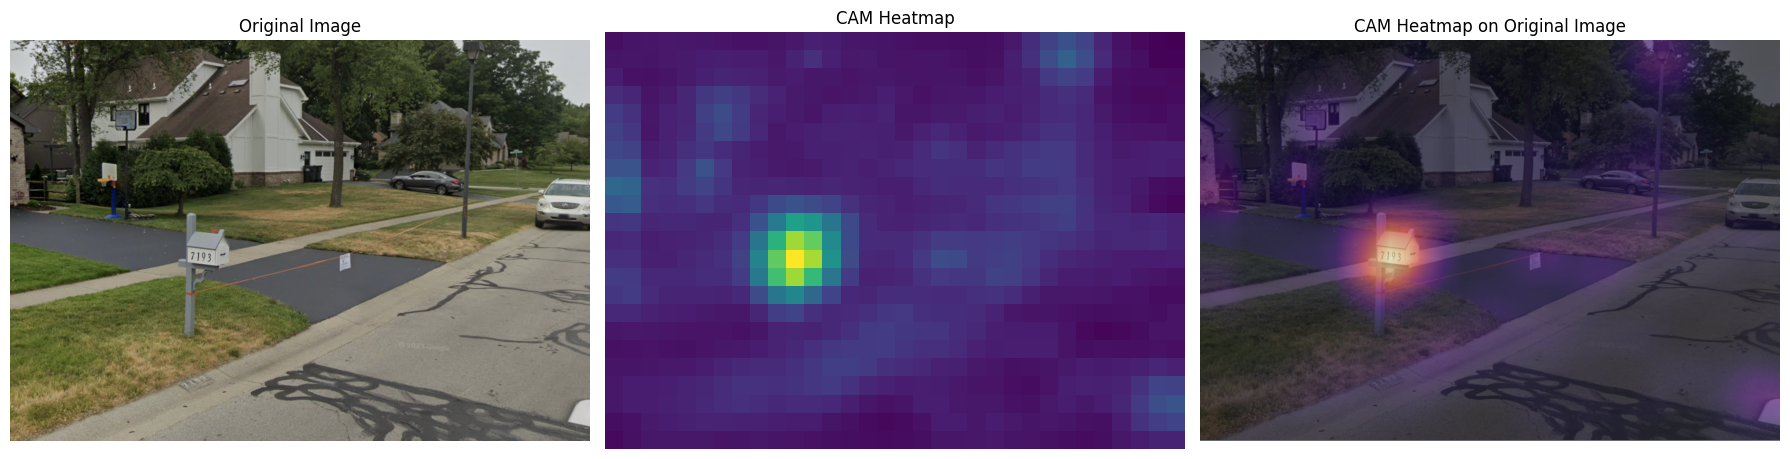

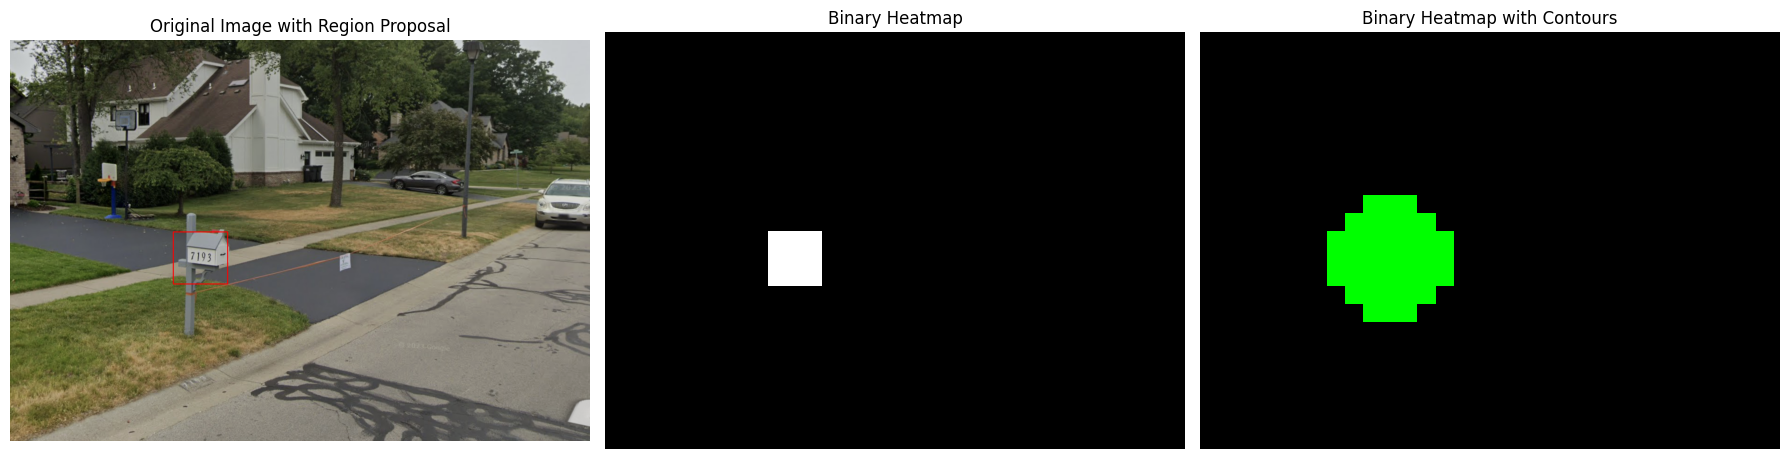

Contour found with coordinates: (468, 549, 624, 698)


detect: weights=['/Users/zhaozhiyu/Downloads/best-2.pt'], source=/tmp/SV_33.png, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/Users/zhaozhiyu/Downloads, name=detection_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.11.4 torch-2.3.0 CPU

Fusing layers... 
yolov3 summary: 190 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
image 1/1 /private/tmp/SV_33.png: 320x320 1 1, 1 3, 1 7, 1 9, 149.3ms
Speed: 0.3ms pre-process, 149.3ms inference, 4.0ms NMS per image at shape (1, 3, 320, 320)
Results saved to /Users/zhaozhiyu/Downloads/detection_results
5 labels saved to /Users/zhaozhiyu/Downloads/detection_results/labels


YOLOv3 detection completed. Results are saved in /Users/zhaozhiyu/Downloads/detection_results


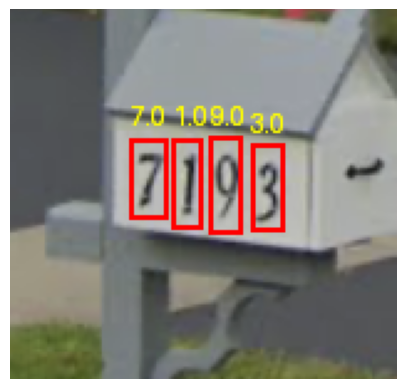

In [375]:
img_path = '/Users/zhaozhiyu/Downloads/SV_33.png'

detect_num_on_mailbox(conf_score, img_path, weights_path, output_dir, visualize=True)


## Detection Example #2: Streetview image more focused on mailbox

ResNet34 Top 5 Predictions:
Class 637, mailbox, Classification Percentage: 13.57%
Class 412, ashcan, Classification Percentage: 9.37%
Class 912, worm_fence, Classification Percentage: 4.29%
Class 856, thresher, Classification Percentage: 4.28%
Class 410, apiary, Classification Percentage: 3.39%



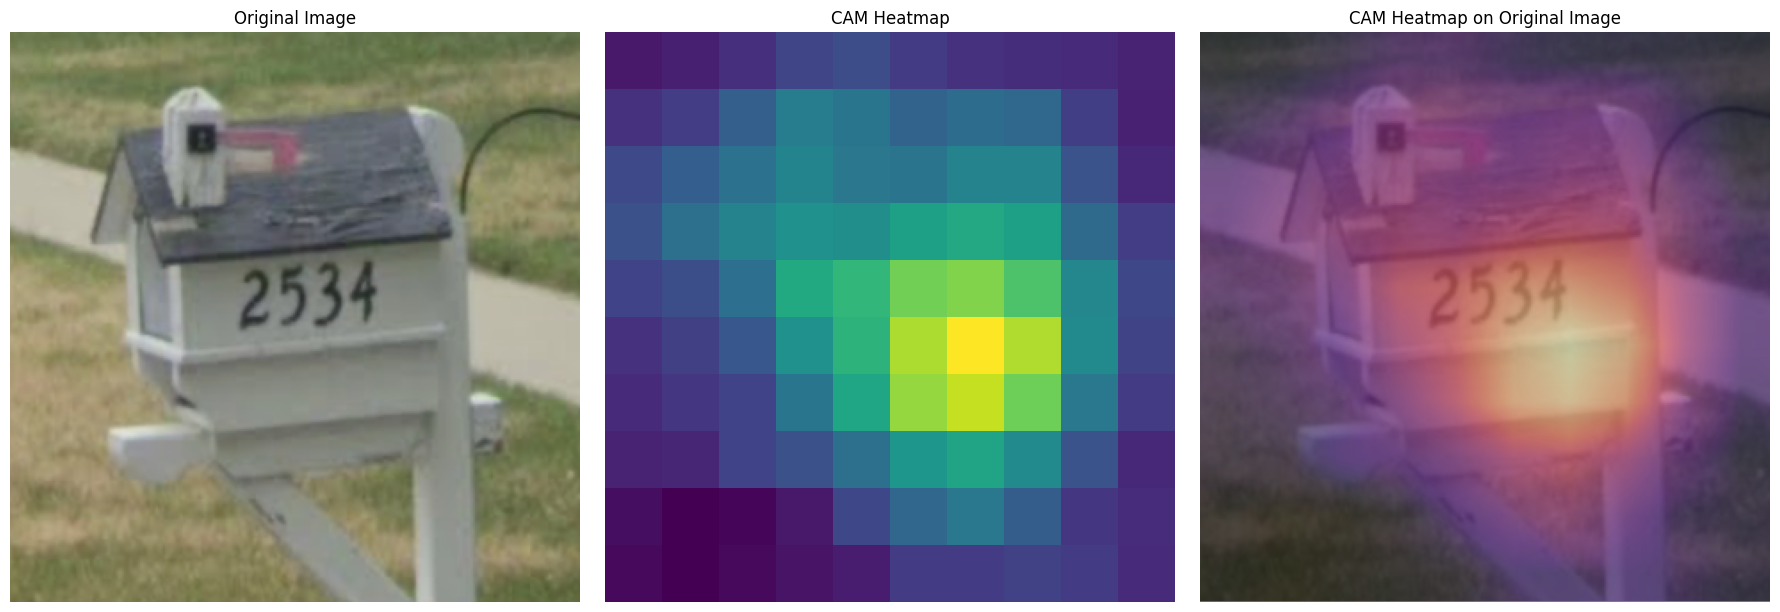

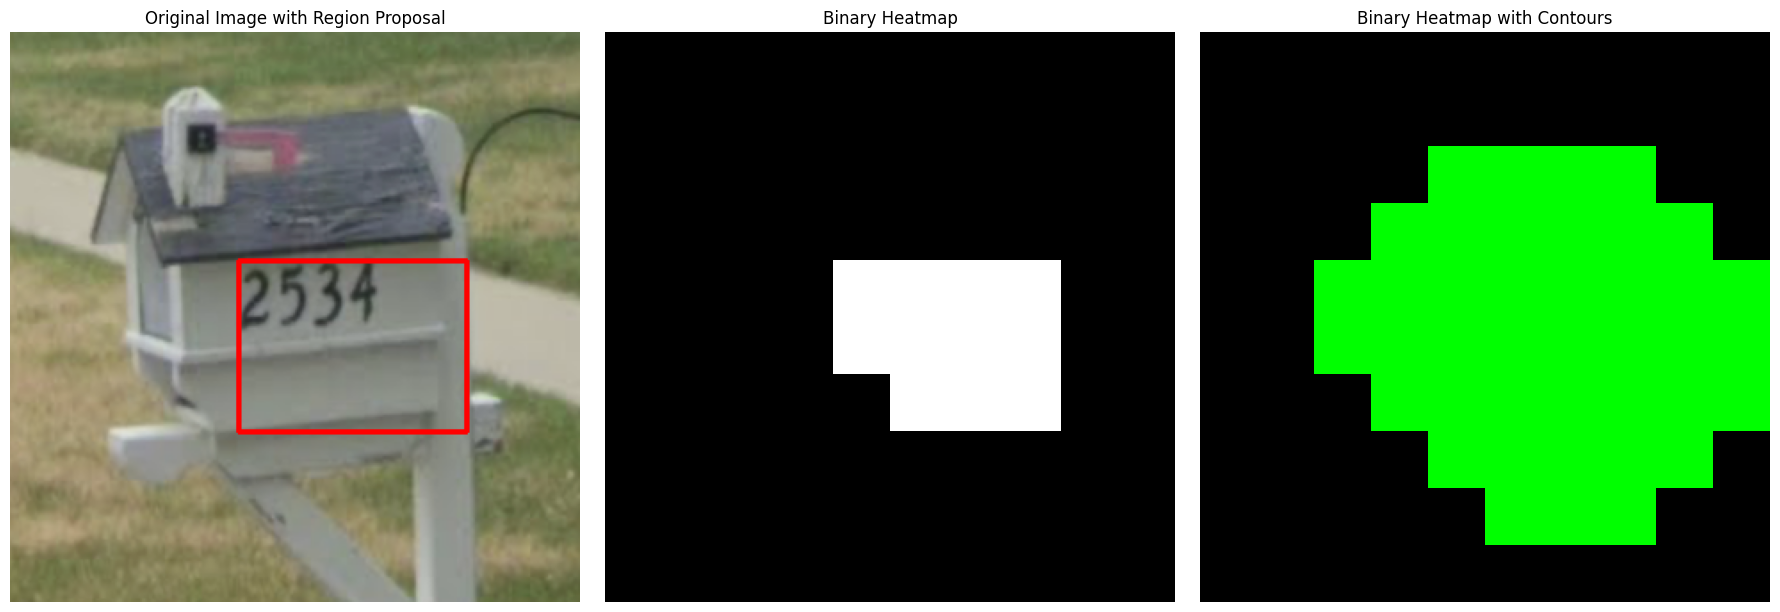

Contour found with coordinates: (128, 128, 256, 224)


detect: weights=['/Users/zhaozhiyu/Downloads/best-2.pt'], source=/tmp/SV_34.png, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/Users/zhaozhiyu/Downloads, name=detection_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.11.4 torch-2.3.0 CPU

Fusing layers... 
yolov3 summary: 190 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
image 1/1 /private/tmp/SV_34.png: 256x320 1 2, 1 3, 1 4, 1 5, 144.2ms
Speed: 0.9ms pre-process, 144.2ms inference, 4.4ms NMS per image at shape (1, 3, 320, 320)
Results saved to /Users/zhaozhiyu/Downloads/detection_results
6 labels saved to /Users/zhaozhiyu/Downloads/detection_results/labels


YOLOv3 detection completed. Results are saved in /Users/zhaozhiyu/Downloads/detection_results


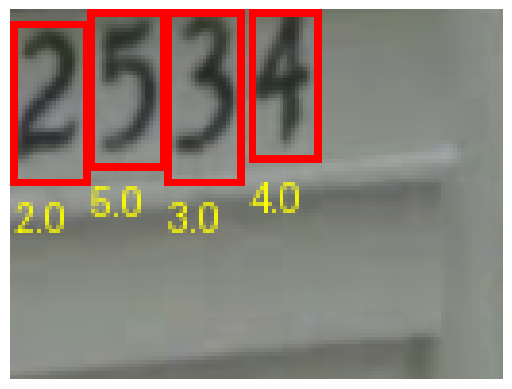

In [376]:
img_path = '/Users/zhaozhiyu/Downloads/SV_34.png'

detect_num_on_mailbox(conf_score, img_path, weights_path, output_dir, visualize=True)


## Detection Example #3: Less confident/incorrect prediction with loose bounding box

ResNet34 Top 5 Predictions:
Class 975, lakeside, Classification Percentage: 2.11%
Class 977, sandbar, Classification Percentage: 1.64%
Class 603, horse_cart, Classification Percentage: 1.64%
Class 733, pole, Classification Percentage: 1.62%
Class 853, thatch, Classification Percentage: 1.38%



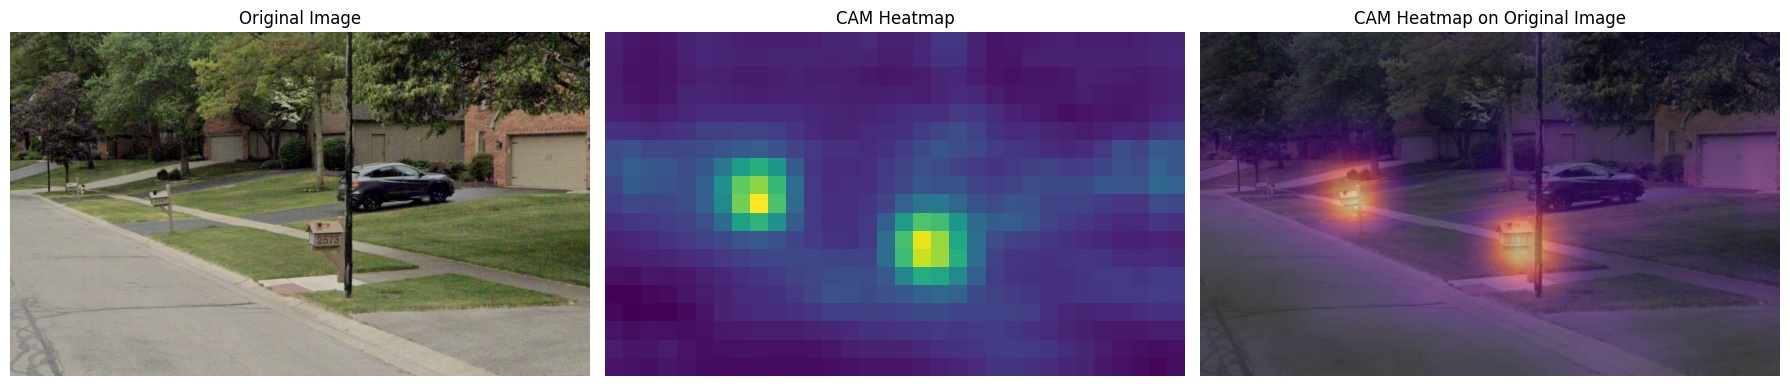

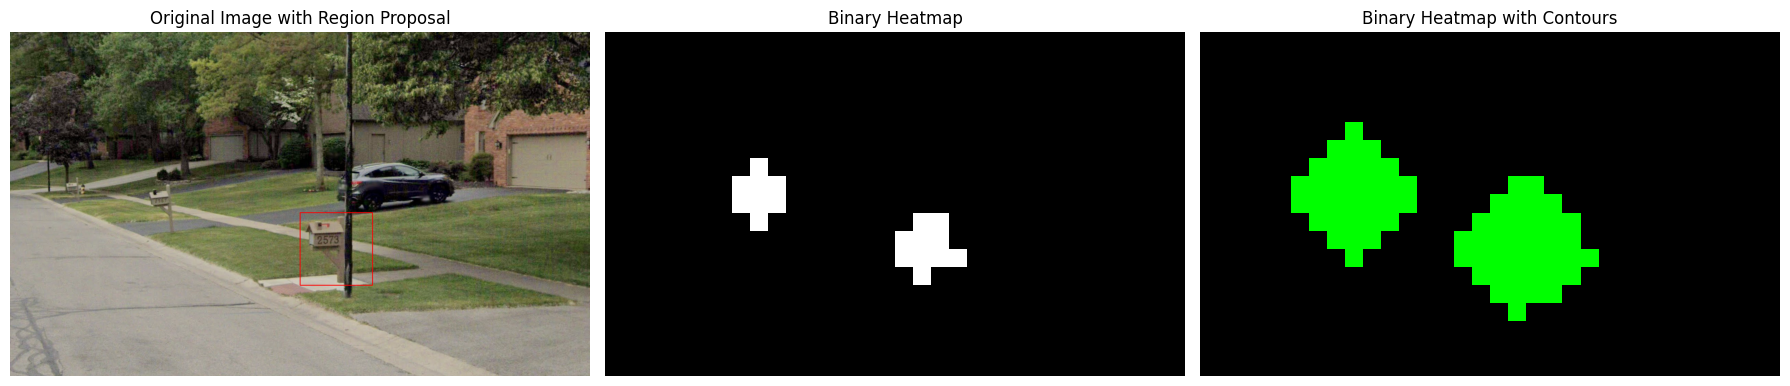

Contour found with coordinates: (997, 623, 1246, 872)


detect: weights=['/Users/zhaozhiyu/Downloads/best-2.pt'], source=/tmp/SV_35.png, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/Users/zhaozhiyu/Downloads, name=detection_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.11.4 torch-2.3.0 CPU

Fusing layers... 
yolov3 summary: 190 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
image 1/1 /private/tmp/SV_35.png: 320x320 1 2, 1 6, 1 7, 146.1ms
Speed: 0.1ms pre-process, 146.1ms inference, 4.1ms NMS per image at shape (1, 3, 320, 320)
Results saved to /Users/zhaozhiyu/Downloads/detection_results
7 labels saved to /Users/zhaozhiyu/Downloads/detection_results/labels


YOLOv3 detection completed. Results are saved in /Users/zhaozhiyu/Downloads/detection_results


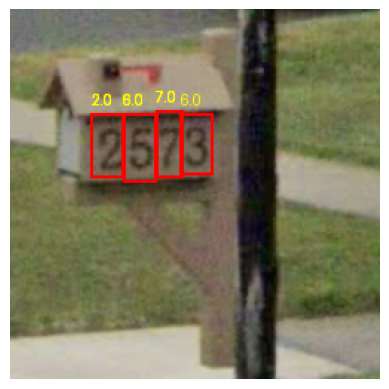

In [382]:
img_path = '/Users/zhaozhiyu/Downloads/SV_35.png'

detect_num_on_mailbox(conf_score, img_path, weights_path, output_dir, visualize=True)


## #3 Cont.: But could use images from different angles for better together prediction

ResNet34 Top 5 Predictions:
Class 660, mobile_home, Classification Percentage: 1.38%
Class 870, tricycle, Classification Percentage: 1.34%
Class 912, worm_fence, Classification Percentage: 1.30%
Class 412, ashcan, Classification Percentage: 1.25%
Class 703, park_bench, Classification Percentage: 1.22%



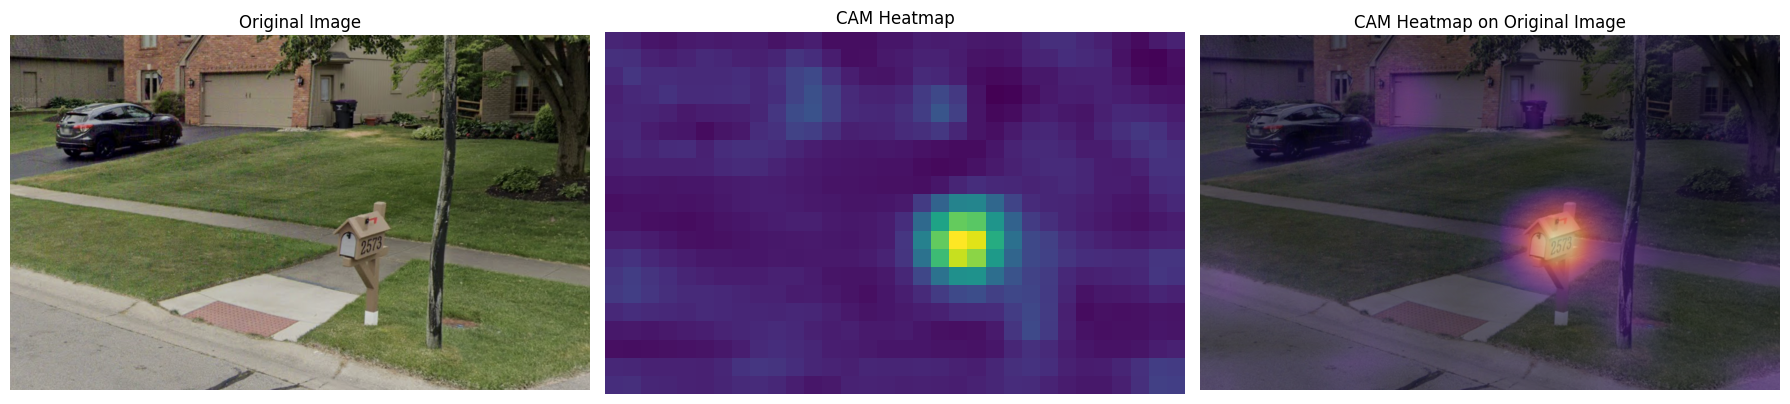

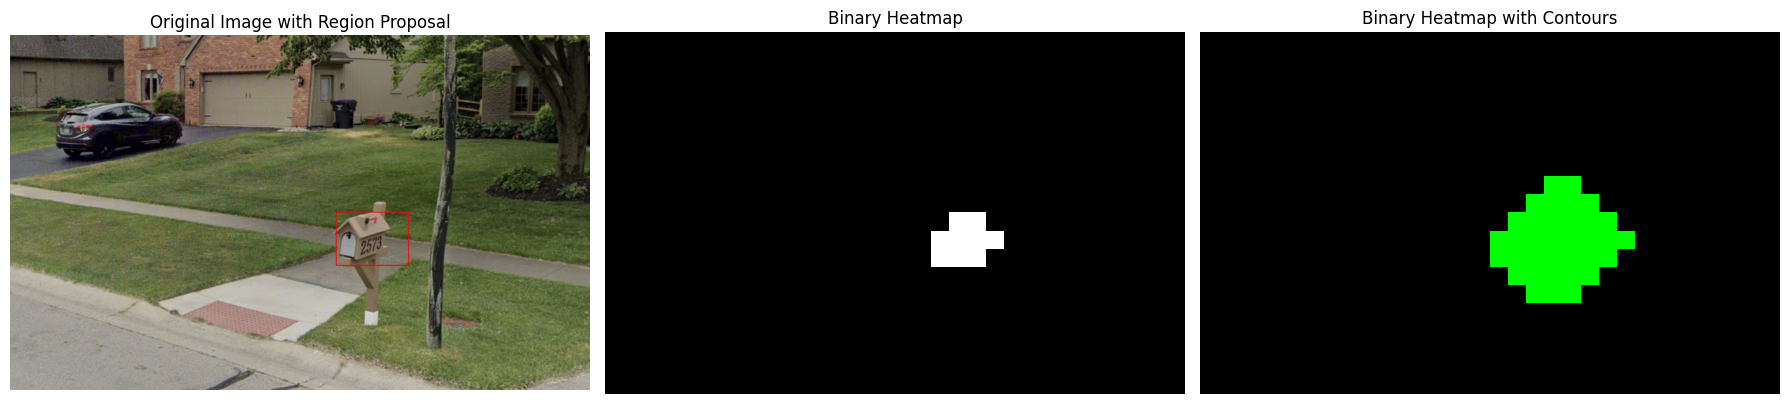

Contour found with coordinates: (1058, 576, 1293, 748)


detect: weights=['/Users/zhaozhiyu/Downloads/best-2.pt'], source=/tmp/SV_36.png, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/Users/zhaozhiyu/Downloads, name=detection_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.11.4 torch-2.3.0 CPU

Fusing layers... 
yolov3 summary: 190 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
image 1/1 /private/tmp/SV_36.png: 256x320 1 2, 1 3, 1 5, 1 7, 136.7ms
Speed: 0.1ms pre-process, 136.7ms inference, 3.7ms NMS per image at shape (1, 3, 320, 320)
Results saved to /Users/zhaozhiyu/Downloads/detection_results
8 labels saved to /Users/zhaozhiyu/Downloads/detection_results/labels


YOLOv3 detection completed. Results are saved in /Users/zhaozhiyu/Downloads/detection_results


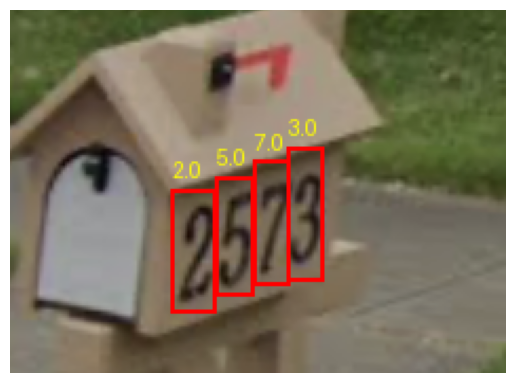

In [383]:
img_path = '/Users/zhaozhiyu/Downloads/SV_36.png'

detect_num_on_mailbox(conf_score, img_path, weights_path, output_dir, visualize=True)
